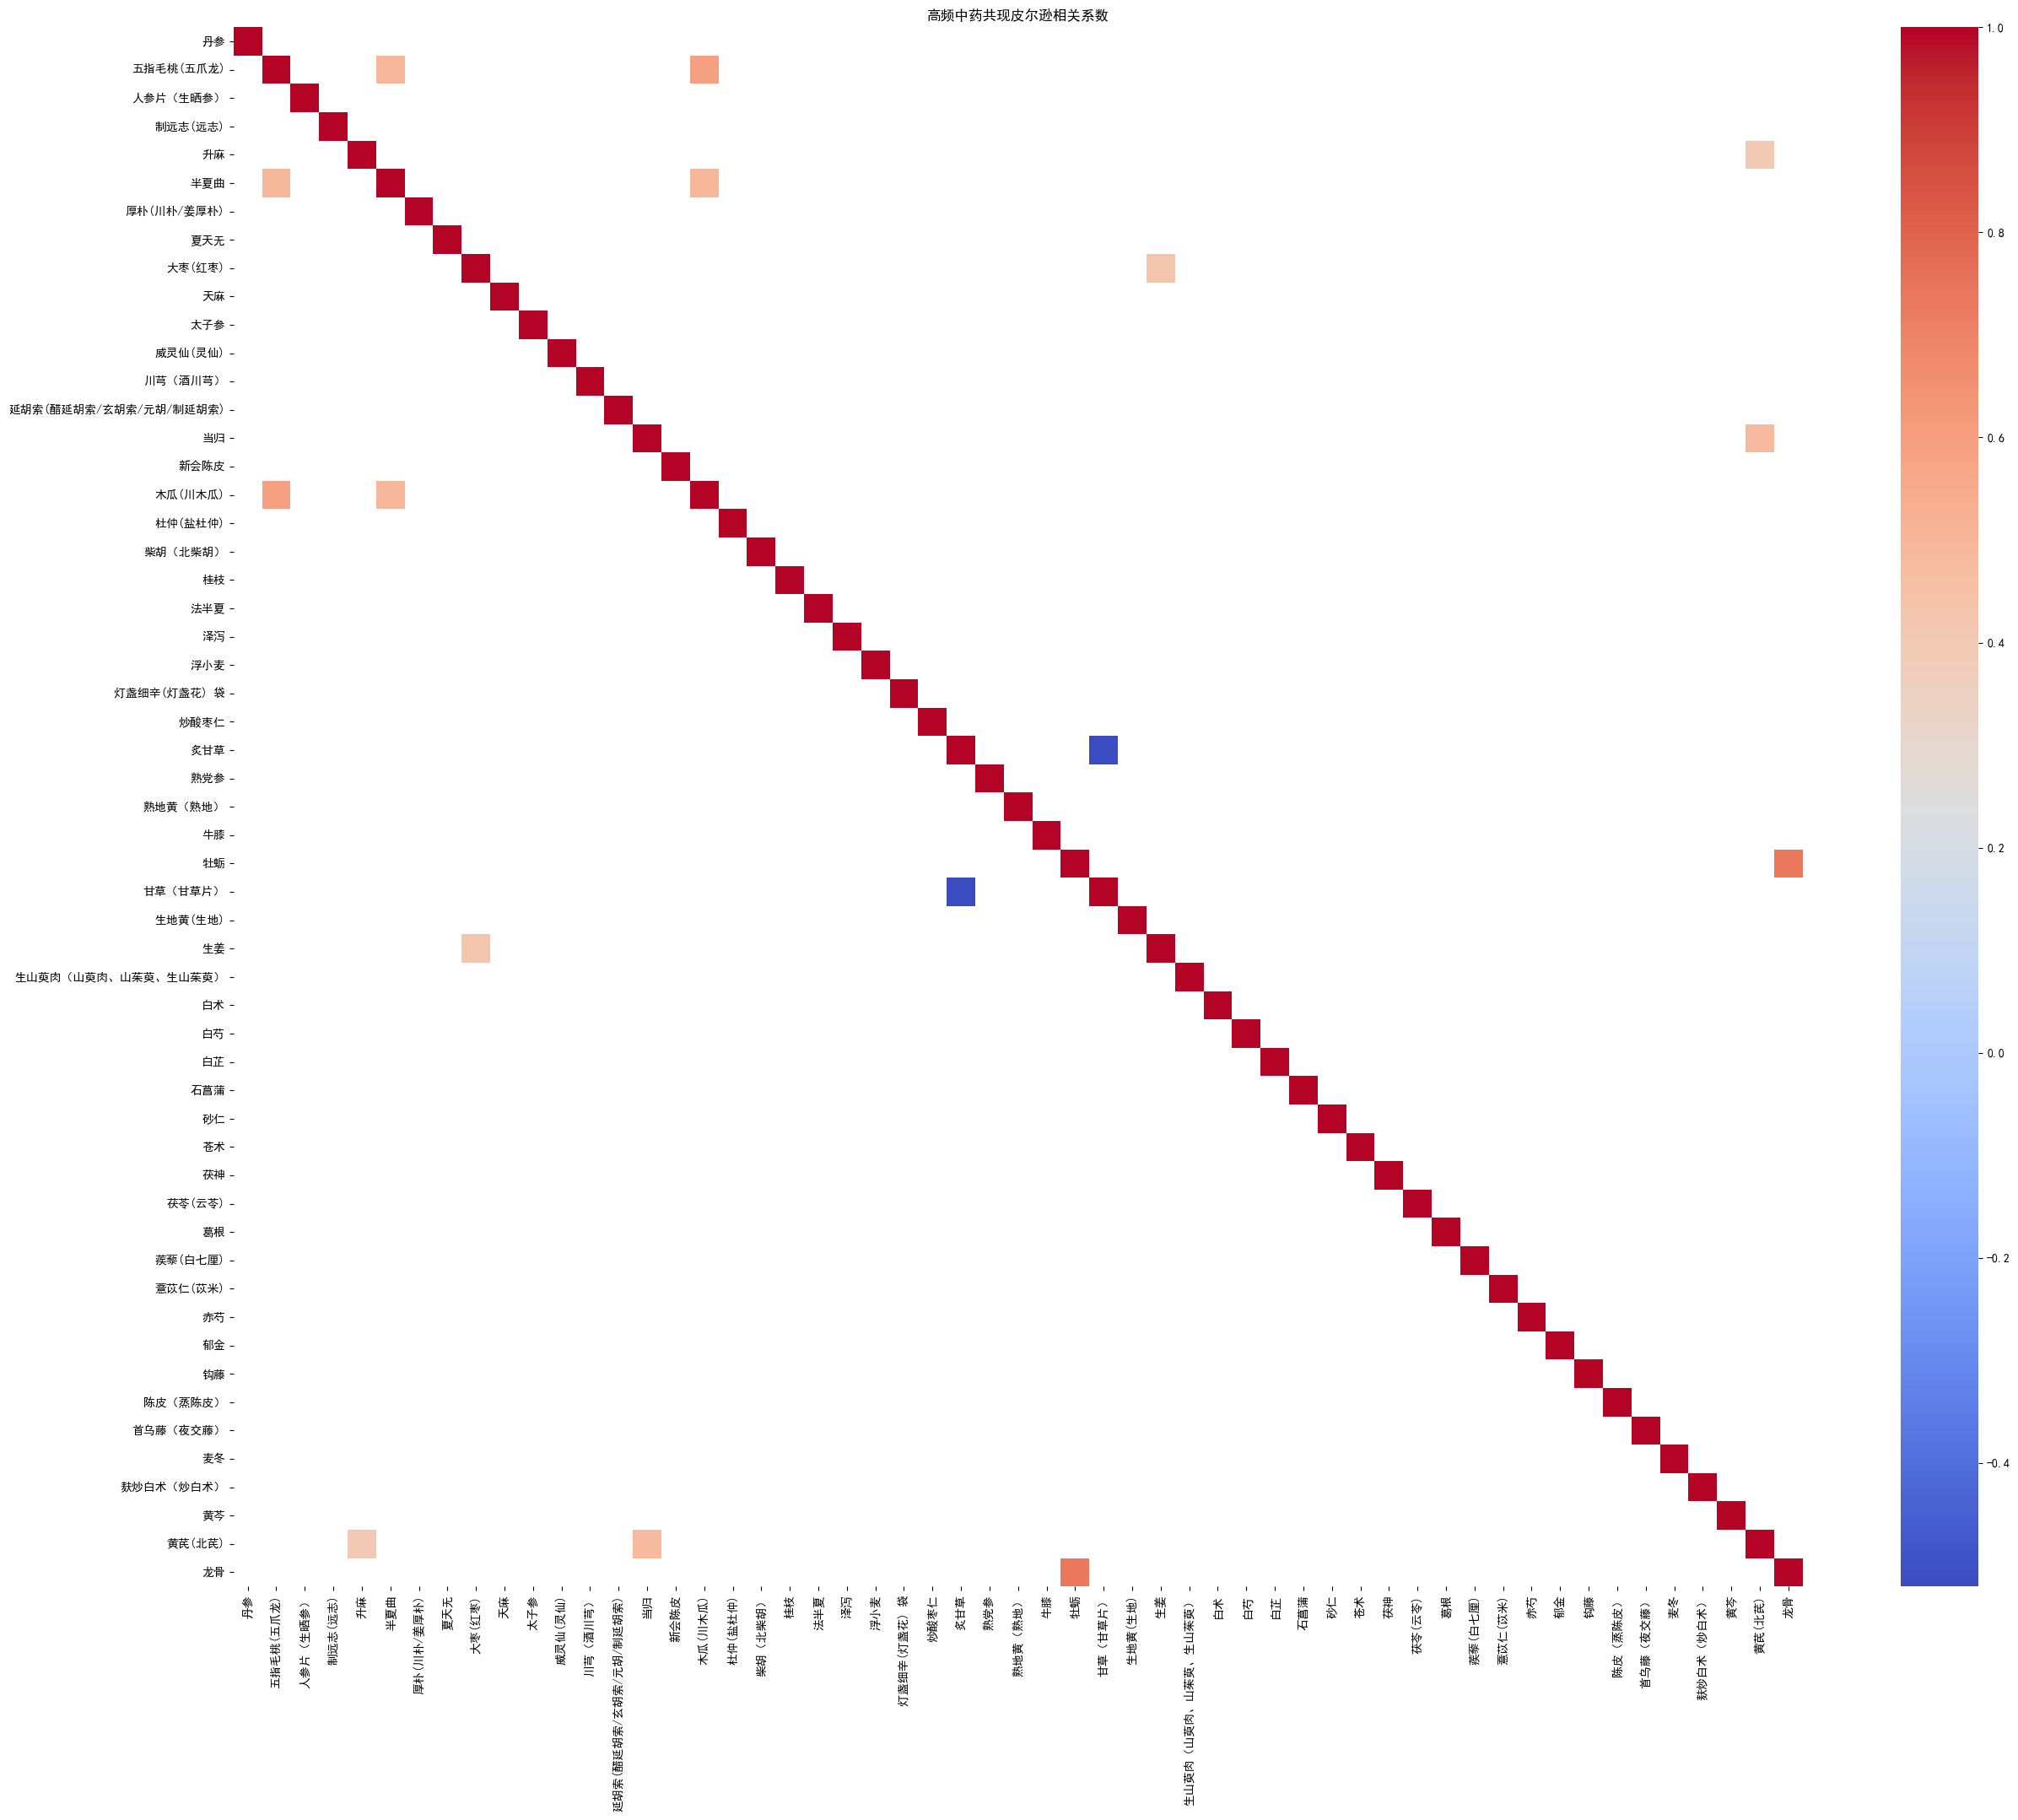

优化后的结果已保存至关联规则结果.xlsx


In [1]:
import pandas as pd
df=pd.read_excel(r"C:\Users\xinre\Desktop\副本723362e533ae5339337c9115433aa483_9172efbc9ea48deb4d61c52119002e70_8.xlsx",sheet_name='内服中药（不同科室）')
df.pop('就诊科室')

chinese_herbs_columns = ['内服中药'] + [col for col in df.columns if 'Unnamed' in col and df[col].notnull().any()]  
for col in chinese_herbs_columns:  
        df[col] = df[col].str.split("量:", expand=True)[0] .str.replace(r"\s+", " ", regex=True).str.strip()

frequency = df.stack().value_counts()

from sklearn.preprocessing import MultiLabelBinarizer  
from scipy.stats import pearsonr  
import itertools  
  
chinese_herbs_columns = []  
  
chinese_herbs_columns = ['内服中药'] + [col for col in df.columns if 'Unnamed' in col and df[col].notnull().any()]  
  
# 提取所有中药列并合并为一个列表  
all_herbs_list = []  
for idx, row in df.iterrows():  
    herbs = []  
    for col in chinese_herbs_columns:  
        value = row[col]  
        if pd.notnull(value) and value != 'nan':  # 排除NaN和字符串'nan'  
            herbs.append(str(value).strip())  # 转换为字符串并去除两端空格  
    all_herbs_list.append(herbs)  

    
# 统计中药频次  
herb_counts = {}  
for herbs in all_herbs_list:  
    for herb in herbs:  
        herb_counts[herb] = herb_counts.get(herb, 0) + 1 
        
# 筛选高频中药（频次 > 100）  
high_freq_herbs = [herb for herb, count in herb_counts.items() if count > 600]  


filtered_herbs_list = [
    [herb for herb in herbs if herb in high_freq_herbs]
    for herbs in all_herbs_list
]

mlb = MultiLabelBinarizer()
binary_matrix = pd.DataFrame(
    mlb.fit_transform(filtered_herbs_list),
    columns=mlb.classes_,
    index=df.index
)

correlation_matrix = binary_matrix.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']=['SimHei'] #用来设定无衬线字体样式
plt.rcParams["font.family"] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(30, 24))

sns.heatmap(
    correlation_matrix,
    cmap="coolwarm",
    annot=False,  # 关闭注释避免重叠
    mask=correlation_matrix.abs() < 0.4 # 仅显示相关性较强的区域
)
plt.title("高频中药共现皮尔逊相关系数")
plt.show()

#############
#############
#############
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 数据预处理（保持不变）
# 示例数据（每行是一个处方的药材列表）

all_herbs_list

# 2. 转换为布尔矩阵
te = TransactionEncoder()
te_ary = te.fit(all_herbs_list).transform(all_herbs_list)
binary_df = pd.DataFrame(te_ary, columns=te.columns_)


# 生成二阶规则（修改部分）
frequent_itemsets_2 = apriori(binary_df, min_support=0.2, use_colnames=True, max_len=2)
rules_2 = association_rules(frequent_itemsets_2, metric="lift", min_threshold=1.0)

# 转换集合为字符串
def frozenset_to_str(column):
    return column.apply(lambda x: ', '.join(list(x)))

rules_2['antecedents'] = frozenset_to_str(rules_2['antecedents'])
rules_2['consequents'] = frozenset_to_str(rules_2['consequents'])

# 筛选并排序
rules_2_order = rules_2[rules_2['antecedents'].apply(lambda x: len(x.split(', ')) == 1)].sort_values(by='lift', ascending=False)

# 生成三阶规则（修改部分）
frequent_itemsets_3 = apriori(binary_df, min_support=0.2, use_colnames=True, max_len=3)
rules_3 = association_rules(frequent_itemsets_3, metric="lift", min_threshold=1.0)

# 转换集合为字符串
rules_3['antecedents'] = frozenset_to_str(rules_3['antecedents'])
rules_3['consequents'] = frozenset_to_str(rules_3['consequents'])

# 筛选并排序
rules_3_order = rules_3[rules_3['antecedents'].apply(lambda x: len(x.split(', ')) == 2)].sort_values(by='lift', ascending=False)

# 保存为Excel（保持不变）
with pd.ExcelWriter(r'C:\Users\xinre\Desktop\关联规则结果.xlsx') as writer:
    rules_2_order[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_excel(
        writer,
        sheet_name='二阶关联规则',
        index=False
    )
    rules_3_order[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_excel(
        writer,
        sheet_name='三阶关联规则',
        index=False,
        startrow=0
    )

print("优化后的结果已保存至关联规则结果.xlsx")

In [3]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 1. 数据预处理（假设 all_herbs_list 是处方的药材列表）
# 示例数据：
all_herbs_list

# 2. 转换为布尔矩阵
te = TransactionEncoder()
te_ary = te.fit(all_herbs_list).transform(all_herbs_list)
binary_df = pd.DataFrame(te_ary, columns=te.columns_)

# 3. 挖掘频繁项集（频次高的组合）
frequent_itemsets = apriori(binary_df, min_support=0.2, use_colnames=True)

# 4. 生成关联规则
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

# 5. 按提升度排序
rules = rules.sort_values(by=['lift'], ascending=False)

print("关联规则：")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

关联规则：
          antecedents        consequents   support  confidence      lift
31               (葛根)      (天麻, 川芎（酒川芎）)  0.206275    0.494662  1.670236
26      (天麻, 川芎（酒川芎）)               (葛根)  0.206275    0.696492  1.670236
48       (茯苓(云苓), 葛根)          (川芎（酒川芎）)  0.225143    0.756680  1.651670
49          (川芎（酒川芎）)       (茯苓(云苓), 葛根)  0.225143    0.491439  1.651670
30          (川芎（酒川芎）)           (天麻, 葛根)  0.206275    0.450255  1.630595
27           (天麻, 葛根)          (川芎（酒川芎）)  0.206275    0.747025  1.630595
46  (茯苓(云苓), 川芎（酒川芎）)               (葛根)  0.225143    0.669820  1.606275
51               (葛根)  (茯苓(云苓), 川芎（酒川芎）)  0.225143    0.539908  1.606275
20       (天麻, 茯苓(云苓))          (川芎（酒川芎）)  0.228429    0.671549  1.465847
25          (川芎（酒川芎）)       (天麻, 茯苓(云苓))  0.228429    0.498612  1.465847
39               (葛根)       (天麻, 茯苓(云苓))  0.207759    0.498221  1.464697
36       (天麻, 茯苓(云苓))               (葛根)  0.207759    0.610782  1.464697
41  (茯苓(云苓), 川芎（酒川芎）)               (白术)  0.2

In [5]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
31,(葛根),"(天麻, 川芎（酒川芎）)",0.417002,0.296163,0.206275,0.494662,1.670236,0.082775,1.392805,0.688309
26,"(天麻, 川芎（酒川芎）)",(葛根),0.296163,0.417002,0.206275,0.696492,1.670236,0.082775,1.920867,0.570135
48,"(茯苓(云苓), 葛根)",(川芎（酒川芎）),0.297541,0.458130,0.225143,0.756680,1.651670,0.088831,2.226982,0.561673
49,(川芎（酒川芎）),"(茯苓(云苓), 葛根)",0.458130,0.297541,0.225143,0.491439,1.651670,0.088831,1.381269,0.728131
30,(川芎（酒川芎）),"(天麻, 葛根)",0.458130,0.276129,0.206275,0.450255,1.630595,0.079772,1.316739,0.713690
27,"(天麻, 葛根)",(川芎（酒川芎）),0.276129,0.458130,0.206275,0.747025,1.630595,0.079772,2.141989,0.534249
46,"(茯苓(云苓), 川芎（酒川芎）)",(葛根),0.336125,0.417002,0.225143,0.669820,1.606275,0.084978,1.765698,0.568543
51,(葛根),"(茯苓(云苓), 川芎（酒川芎）)",0.417002,0.336125,0.225143,0.539908,1.606275,0.084978,1.442920,0.647415
20,"(天麻, 茯苓(云苓))",(川芎（酒川芎）),0.340153,0.458130,0.228429,0.671549,1.465847,0.072595,1.649773,0.481627
25,(川芎（酒川芎）),"(天麻, 茯苓(云苓))",0.458130,0.340153,0.228429,0.498612,1.465847,0.072595,1.316041,0.586489


In [12]:
frequency

茯苓(云苓)                6031
天麻                    4957
白术                    4687
川芎（酒川芎）               4365
葛根                    3970
                      ... 
独活                       1
陈皮（蒸陈皮）                  1
苍术                       1
厚朴(川朴/姜厚朴)               1
当归炭                      1
Length: 588, dtype: int64

In [13]:
import xlwings as xw
xw.view(frequency)

In [14]:
df

,内服中药,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76
0,熟地黄（熟地）,白芍,牛膝,熟党参,丹参,首乌藤（夜交藤）,茯神,炙甘草,知母,黄连,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,天麻,钩藤,石决明,麸炒枳实,杜仲(盐杜仲),牛膝,黄芩,桑寄生(杂寄生）,首乌藤（夜交藤）,茯神,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,川芎（酒川芎）,白芍,牛膝,天麻,法半夏,熟地黄（熟地）,茯苓(云苓),炙甘草,人参片（生晒参）,木瓜(川木瓜),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,茯苓(云苓),白术,甘草（甘草片）,葛根,升麻,黄芪(北芪),当归,泽泻,蔓荆子（荆子）,熟党参,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,炒黄连,关黄柏(黄柏),熟附子（黑顺片、附片）,细辛,桂枝,花椒(川椒),乌梅,干姜,熟党参,当归,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9429,甘草（甘草片）,川芎（酒川芎）,藁本,牛膝,柴胡（北柴胡）,新会陈皮,熟地黄（熟地）,竹茹,半夏曲,蒺藜(白七厘),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9430,生山萸肉（山萸肉、山茱萸、生山茱萸）,蒺藜(白七厘),酒川牛膝,宽筋藤,延胡索(醋延胡索/玄胡索/元胡/制延胡索),天麻,白芷,甘草（甘草片）,灯盏细辛(灯盏花) 袋,白术,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9431,法半夏,天麻,白术,熟党参,川芎（酒川芎）,蒺藜(白七厘),黄芪(北芪),白芍,丹参,鹿衔草（鹿含草）,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9432,络石藤(广东络石藤),杜仲(盐杜仲),天麻,赤芍,茯苓(云苓),钩藤,夏枯草,丹参,泽泻,菊花,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
xw.view(frequency)

In [17]:
import numpy as np


# 定义区间边界和标签
bins = [1,10,30, 50, 100, np.inf]  # 10 <= x <30, 30 <=x <50, 50 <=x <100, x >=100
labels = ['[1,10)','[10,30)', '[30,50)', '[50,100)', '>=100']

# 将频次分配到区间并统计数量
interval_counts = (
    pd.cut(frequency, bins=bins, labels=labels, right=False)  # right=False 表示左闭右开
    .value_counts()                                           # 统计区间频次
    .reindex(labels, fill_value=0)                            # 确保所有区间都显示，缺失的补0
    .reset_index(name='数量')                                  # 转为 DataFrame 并重命名列
    .rename(columns={'index': '频次区间'})
)

print(interval_counts)

       频次区间   数量
0    [1,10)  233
1   [10,30)   91
2   [30,50)   30
3  [50,100)   56
4     >=100  178


In [18]:
frequency

茯苓(云苓)                6031
天麻                    4957
白术                    4687
川芎（酒川芎）               4365
葛根                    3970
                      ... 
独活                       1
陈皮（蒸陈皮）                  1
苍术                       1
厚朴(川朴/姜厚朴)               1
当归炭                      1
Length: 588, dtype: int64

In [73]:
frequency[frequency > 600]

茯苓(云苓)                   6031
天麻                       4957
白术                       4687
川芎（酒川芎）                  4365
葛根                       3970
甘草（甘草片）                  3747
炙甘草                      3147
桂枝                       2779
法半夏                      2650
熟党参                      2609
石菖蒲                      2497
白芍                       2465
柴胡（北柴胡）                  2434
黄芪(北芪)                   2351
当归                       2049
陈皮（蒸陈皮）                  1985
半夏曲                      1846
丹参                       1774
黄芩                       1764
新会陈皮                     1758
五指毛桃(五爪龙)                1735
泽泻                       1578
白芷                       1561
牛膝                       1415
大枣(红枣)                   1310
威灵仙(灵仙)                  1193
生地黄(生地)                  1069
蒺藜(白七厘)                  1069
首乌藤（夜交藤）                 1032
人参片（生晒参）                 1005
砂仁                        934
赤芍                        927
钩藤                        926
木瓜(川木瓜)   

In [26]:
df

,内服中药,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76
0,熟地黄（熟地）,白芍,牛膝,熟党参,丹参,首乌藤（夜交藤）,茯神,炙甘草,知母,黄连,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,天麻,钩藤,石决明,麸炒枳实,杜仲(盐杜仲),牛膝,黄芩,桑寄生(杂寄生）,首乌藤（夜交藤）,茯神,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,川芎（酒川芎）,白芍,牛膝,天麻,法半夏,熟地黄（熟地）,茯苓(云苓),炙甘草,人参片（生晒参）,木瓜(川木瓜),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,茯苓(云苓),白术,甘草（甘草片）,葛根,升麻,黄芪(北芪),当归,泽泻,蔓荆子（荆子）,熟党参,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,炒黄连,关黄柏(黄柏),熟附子（黑顺片、附片）,细辛,桂枝,花椒(川椒),乌梅,干姜,熟党参,当归,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9429,甘草（甘草片）,川芎（酒川芎）,藁本,牛膝,柴胡（北柴胡）,新会陈皮,熟地黄（熟地）,竹茹,半夏曲,蒺藜(白七厘),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9430,生山萸肉（山萸肉、山茱萸、生山茱萸）,蒺藜(白七厘),酒川牛膝,宽筋藤,延胡索(醋延胡索/玄胡索/元胡/制延胡索),天麻,白芷,甘草（甘草片）,灯盏细辛(灯盏花) 袋,白术,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9431,法半夏,天麻,白术,熟党参,川芎（酒川芎）,蒺藜(白七厘),黄芪(北芪),白芍,丹参,鹿衔草（鹿含草）,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9432,络石藤(广东络石藤),杜仲(盐杜仲),天麻,赤芍,茯苓(云苓),钩藤,夏枯草,丹参,泽泻,菊花,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
mlb = MultiLabelBinarizer()
binary_matrix = pd.DataFrame(
    mlb.fit_transform(df["药材列表"]),
    columns=mlb.classes_,
    index=df.index
)

print(binary_matrix)

NameError: name 'MultiLabelBinarizer' is not defined

In [29]:
data = {
    "处方ID": [1, 2, 3],
    "药材列表": ["黄芪,甘草,当归", "甘草,人参", "黄芪,黄连,甘草"]
}
df = pd.DataFrame(data)

# 将字符串拆分为列表
df["药材列表"] = df["药材列表"].str.split(",")

In [31]:
df["药材列表"]

0    [黄芪, 甘草, 当归]
1        [甘草, 人参]
2    [黄芪, 黄连, 甘草]
Name: 药材列表, dtype: object

In [32]:
df = pd.DataFrame({
     '处方': [
        ['黄芪', '当归', '白术'],
        ['当归', '熟地', '川芎'],
        ['黄芪', '熟地', '茯苓']     ]
 })

In [33]:
df

,处方
0,"[黄芪, 当归, 白术]"
1,"[当归, 熟地, 川芎]"
2,"[黄芪, 熟地, 茯苓]"


In [35]:
xw.view(df)

In [36]:
writer = pd.ExcelWriter(r"C:\Users\xinre\Documents\中药测试.xlsx") 
df.to_excel(writer,sheet_name="数据盘",index=False) 

In [37]:
writer.close() 


In [38]:
df

,内服中药,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76
0,熟地黄（熟地）,白芍,牛膝,熟党参,丹参,首乌藤（夜交藤）,茯神,炙甘草,知母,黄连,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,天麻,钩藤,石决明,麸炒枳实,杜仲(盐杜仲),牛膝,黄芩,桑寄生(杂寄生）,首乌藤（夜交藤）,茯神,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,川芎（酒川芎）,白芍,牛膝,天麻,法半夏,熟地黄（熟地）,茯苓(云苓),炙甘草,人参片（生晒参）,木瓜(川木瓜),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,茯苓(云苓),白术,甘草（甘草片）,葛根,升麻,黄芪(北芪),当归,泽泻,蔓荆子（荆子）,熟党参,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,炒黄连,关黄柏(黄柏),熟附子（黑顺片、附片）,细辛,桂枝,花椒(川椒),乌梅,干姜,熟党参,当归,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9429,甘草（甘草片）,川芎（酒川芎）,藁本,牛膝,柴胡（北柴胡）,新会陈皮,熟地黄（熟地）,竹茹,半夏曲,蒺藜(白七厘),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9430,生山萸肉（山萸肉、山茱萸、生山茱萸）,蒺藜(白七厘),酒川牛膝,宽筋藤,延胡索(醋延胡索/玄胡索/元胡/制延胡索),天麻,白芷,甘草（甘草片）,灯盏细辛(灯盏花) 袋,白术,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9431,法半夏,天麻,白术,熟党参,川芎（酒川芎）,蒺藜(白七厘),黄芪(北芪),白芍,丹参,鹿衔草（鹿含草）,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9432,络石藤(广东络石藤),杜仲(盐杜仲),天麻,赤芍,茯苓(云苓),钩藤,夏枯草,丹参,泽泻,菊花,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
from sklearn.preprocessing import MultiLabelBinarizer  
from scipy.stats import pearsonr   
# 合并所有中药列  
# 假设中药列从第2列开始（'内服中药'列），直到最后一个非空列  
# 这里使用列表推导式收集所有非空中药列  
chinese_herbs_columns = []  
  
chinese_herbs_columns = ['内服中药'] + [col for col in df.columns if 'Unnamed' in col and df[col].notnull().any()]  
  
# 提取所有中药列并合并为一个列表  
all_herbs_list = []  
for idx, row in df.iterrows():  
    herbs = []  
    for col in chinese_herbs_columns:  
        value = row[col]  
        if pd.notnull(value) and value != 'nan':  # 排除NaN和字符串'nan'  
            herbs.append(str(value).strip())  # 转换为字符串并去除两端空格  
    all_herbs_list.append(herbs)  
  
# 转换为二元矩阵  
mlb = MultiLabelBinarizer()  
binary_matrix = pd.DataFrame(  
    mlb.fit_transform(all_herbs_list),  
    columns=mlb.classes_,  
    index=df.index  
)  

In [47]:
all_herbs_list

[['熟地黄（熟地）',
  '白芍',
  '牛膝',
  '熟党参',
  '丹参',
  '首乌藤（夜交藤）',
  '茯神',
  '炙甘草',
  '知母',
  '黄连',
  '法半夏',
  '麸炒枳实',
  '厚朴(川朴/姜厚朴)',
  '合欢皮',
  '麦冬'],
 ['天麻',
  '钩藤',
  '石决明',
  '麸炒枳实',
  '杜仲(盐杜仲)',
  '牛膝',
  '黄芩',
  '桑寄生(杂寄生）',
  '首乌藤（夜交藤）',
  '茯神',
  '川芎（酒川芎）',
  '法半夏',
  '白术',
  '茯苓(云苓)',
  '炙甘草',
  '化橘红胎（化橘红珠）',
  '生姜',
  '熟党参'],
 ['川芎（酒川芎）',
  '白芍',
  '牛膝',
  '天麻',
  '法半夏',
  '熟地黄（熟地）',
  '茯苓(云苓)',
  '炙甘草',
  '人参片（生晒参）',
  '木瓜(川木瓜)',
  '黄芪(北芪)',
  '生山萸肉（山萸肉、山茱萸、生山茱萸）',
  '麸炒白术（炒白术）',
  '麦冬',
  '川芎（酒川芎）',
  '赤芍',
  '牛膝',
  '天麻',
  '法半夏',
  '熟地黄（熟地）',
  '茯苓(云苓)',
  '炙甘草',
  '人参片（生晒参）',
  '木瓜(川木瓜)',
  '黄芪(北芪)',
  '生山萸肉（山萸肉、山茱萸、生山茱萸）',
  '麸炒白术（炒白术）',
  '麦冬'],
 ['茯苓(云苓)',
  '白术',
  '甘草（甘草片）',
  '葛根',
  '升麻',
  '黄芪(北芪)',
  '当归',
  '泽泻',
  '蔓荆子（荆子）',
  '熟党参',
  '九节菖蒲(外菖蒲)',
  '制远志(远志)',
  '龙骨',
  '牡蛎',
  '鹿衔草（鹿含草）',
  '仙鹤草',
  '杜仲(盐杜仲)'],
 ['炒黄连',
  '关黄柏(黄柏)',
  '熟附子（黑顺片、附片）',
  '细辛',
  '桂枝',
  '花椒(川椒)',
  '乌梅',
  '干姜',
  '熟党参',
  '当归'],
 ['龙眼肉',
  '炒薏苡仁',
  '新会陈皮',
  '知母',
  '芡实（茨实）',
  '人参片

In [46]:
correlation_matrix = binary_matrix.corr()
import seaborn as sns
import matplotlib.pyplot as plt
# 3. 可视化f
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("中药共现皮尔逊相关系数")
plt.show()

C:\Users\xinre\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 19969 (\N{CJK UNIFIED IDEOGRAPH-4E01}) missing from current font.
  fig.canvas.draw()
C:\Users\xinre\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from current font.
  fig.canvas.draw()
C:\Users\xinre\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 20061 (\N{CJK UNIFIED IDEOGRAPH-4E5D}) missing from current font.
  fig.canvas.draw()
C:\Users\xinre\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 33410 (\N{CJK UNIFIED IDEOGRAPH-8282}) missing from current font.
  fig.canvas.draw()
C:\Users\xinre\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 33750 (\N{CJK UNIFIED IDEOGRAPH-83D6}) missing from current font.
  fig.canvas.draw()
C:\Users\xinre\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 33970 (\N{CJK UNIFIED IDEOGRAPH-84B2}) missing from current font.
  fig.

C:\Users\xinre\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\xinre\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33647 (\N{CJK UNIFIED IDEOGRAPH-836F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\xinre\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20849 (\N{CJK UNIFIED IDEOGRAPH-5171}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\xinre\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29616 (\N{CJK UNIFIED IDEOGRAPH-73B0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\xinre\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30382 (\N{CJK UNIFIED IDEOGRAPH-76AE}) missing from current font.
  fig.canvas.print_figure(bytes_

KeyboardInterrupt: 

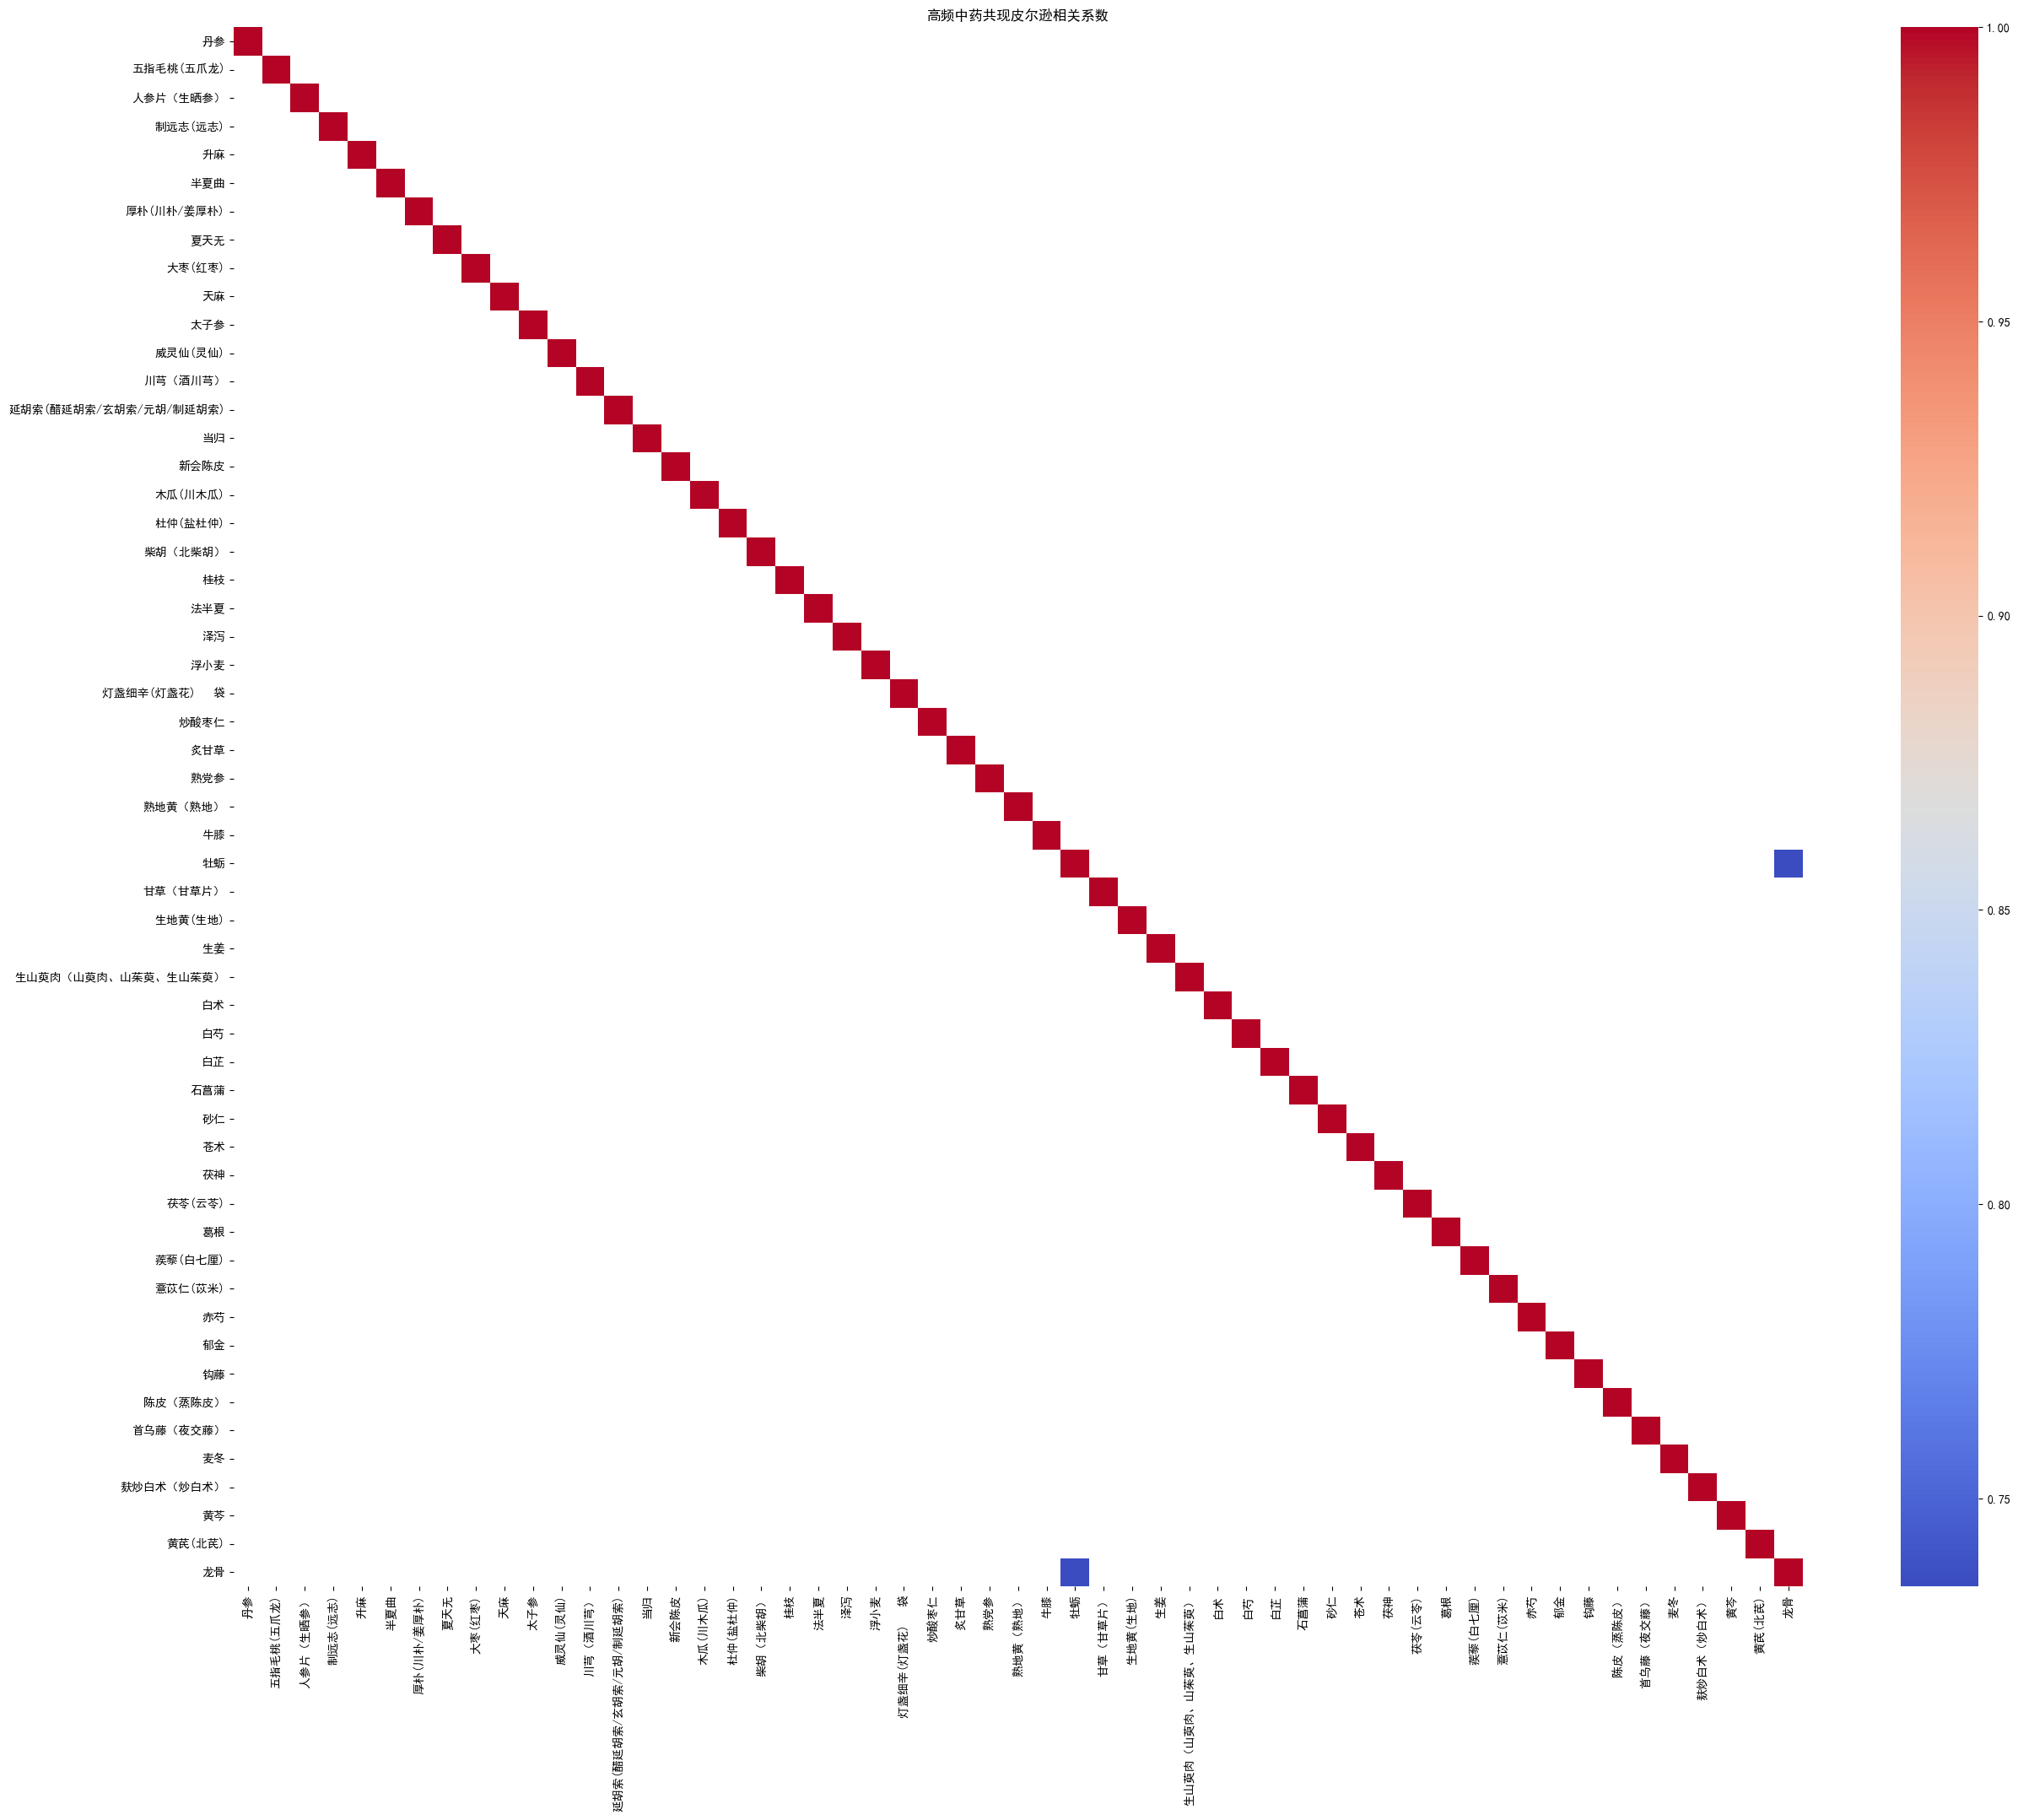

In [79]:
import pandas as pd  
from sklearn.preprocessing import MultiLabelBinarizer  
from scipy.stats import pearsonr  
import itertools  
  
chinese_herbs_columns = []  
  
chinese_herbs_columns = ['内服中药'] + [col for col in df.columns if 'Unnamed' in col and df[col].notnull().any()]  
  
# 提取所有中药列并合并为一个列表  
all_herbs_list = []  
for idx, row in df.iterrows():  
    herbs = []  
    for col in chinese_herbs_columns:  
        value = row[col]  
        if pd.notnull(value) and value != 'nan':  # 排除NaN和字符串'nan'  
            herbs.append(str(value).strip())  # 转换为字符串并去除两端空格  
    all_herbs_list.append(herbs)  

    
# 统计中药频次  
herb_counts = {}  
for herbs in all_herbs_list:  
    for herb in herbs:  
        herb_counts[herb] = herb_counts.get(herb, 0) + 1 
        
# 筛选高频中药（频次 > 100）  
high_freq_herbs = [herb for herb, count in herb_counts.items() if count > 600]  


filtered_herbs_list = [
    [herb for herb in herbs if herb in high_freq_herbs]
    for herbs in all_herbs_list
]

mlb = MultiLabelBinarizer()
binary_matrix = pd.DataFrame(
    mlb.fit_transform(filtered_herbs_list),
    columns=mlb.classes_,
    index=df.index
)

correlation_matrix = binary_matrix.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']=['SimHei'] #用来设定无衬线字体样式
plt.rcParams["font.family"] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(30, 24))

sns.heatmap(
    correlation_matrix,
    cmap="coolwarm",
    annot=False,  # 关闭注释避免重叠
    mask=correlation_matrix.abs() < 0.4 # 仅显示相关性较强的区域
)
plt.title("高频中药共现皮尔逊相关系数")
plt.show()

In [49]:
high_freq_herbs

['熟地黄（熟地）',
 '白芍',
 '牛膝',
 '熟党参',
 '丹参',
 '首乌藤（夜交藤）',
 '茯神',
 '炙甘草',
 '知母',
 '黄连',
 '法半夏',
 '麸炒枳实',
 '厚朴(川朴/姜厚朴)',
 '合欢皮',
 '麦冬',
 '天麻',
 '钩藤',
 '石决明',
 '杜仲(盐杜仲)',
 '黄芩',
 '桑寄生(杂寄生）',
 '川芎（酒川芎）',
 '白术',
 '茯苓(云苓)',
 '化橘红胎（化橘红珠）',
 '生姜',
 '人参片（生晒参）',
 '木瓜(川木瓜)',
 '黄芪(北芪)',
 '生山萸肉（山萸肉、山茱萸、生山茱萸）',
 '麸炒白术（炒白术）',
 '赤芍',
 '甘草（甘草片）',
 '葛根',
 '升麻',
 '当归',
 '泽泻',
 '蔓荆子（荆子）',
 '九节菖蒲(外菖蒲)',
 '制远志(远志)',
 '龙骨',
 '牡蛎',
 '鹿衔草（鹿含草）',
 '仙鹤草',
 '炒黄连',
 '关黄柏(黄柏)',
 '熟附子（黑顺片、附片）',
 '细辛',
 '桂枝',
 '乌梅',
 '干姜',
 '龙眼肉',
 '炒薏苡仁',
 '新会陈皮',
 '芡实（茨实）',
 '柴胡（北柴胡）',
 '苍术',
 '大枣(红枣)',
 '薄荷',
 '牡荆子(黄荆子)',
 '香附（醋/制香附）',
 '陈皮（蒸陈皮）',
 '清半夏',
 '五指毛桃(五爪龙)',
 '半夏曲',
 '石菖蒲',
 '威灵仙(灵仙)',
 '土白术（土炒白术）',
 '三七片(田七片)',
 '桑叶',
 '太子参',
 '五味子（蒸五味子）',
 '菊花',
 '桔梗',
 '浙贝母',
 '红花(川红花)',
 '羌活',
 '独活',
 '桃仁（燀桃仁）',
 '云芝',
 '姜竹茹（姜炒竹茹）',
 '胆南星（胆星）',
 '红芪   袋',
 '夏天无',
 '北沙参',
 '生地黄(生地)',
 '百合',
 '淡竹叶(竹叶)',
 '天花粉(花粉)',
 '肉桂',
 '山药(淮山)',
 '巴戟天（盐巴戟天）',
 '麦芽',
 '磁石(煅磁石)',
 '广东络石藤（络石藤)',
 '珍珠母',
 '制何首乌',
 '炒酸枣仁',
 '酒川牛膝',
 '薏苡仁(苡米)',
 '布渣叶',
 '灯盏

In [50]:

mlb = MultiLabelBinarizer()  
binary_matrix = pd.DataFrame(  
    mlb.fit_transform(high_freq_herbs),  
    columns=mlb.classes_,  
    index=df.index  
)  
  

ValueError: Shape of passed values is (176, 287), indices imply (9434, 287)

C:\Users\xinre\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 19969 (\N{CJK UNIFIED IDEOGRAPH-4E01}) missing from current font.
  fig.canvas.draw()
C:\Users\xinre\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from current font.
  fig.canvas.draw()
C:\Users\xinre\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 20116 (\N{CJK UNIFIED IDEOGRAPH-4E94}) missing from current font.
  fig.canvas.draw()
C:\Users\xinre\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 21619 (\N{CJK UNIFIED IDEOGRAPH-5473}) missing from current font.
  fig.canvas.draw()
C:\Users\xinre\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from current font.
  fig.canvas.draw()
C:\Users\xinre\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.

C:\Users\xinre\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\xinre\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33647 (\N{CJK UNIFIED IDEOGRAPH-836F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\xinre\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20849 (\N{CJK UNIFIED IDEOGRAPH-5171}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\xinre\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29616 (\N{CJK UNIFIED IDEOGRAPH-73B0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\xinre\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30382 (\N{CJK UNIFIED IDEOGRAPH-76AE}) missing from current font.
  fig.canvas.print_figure(bytes_

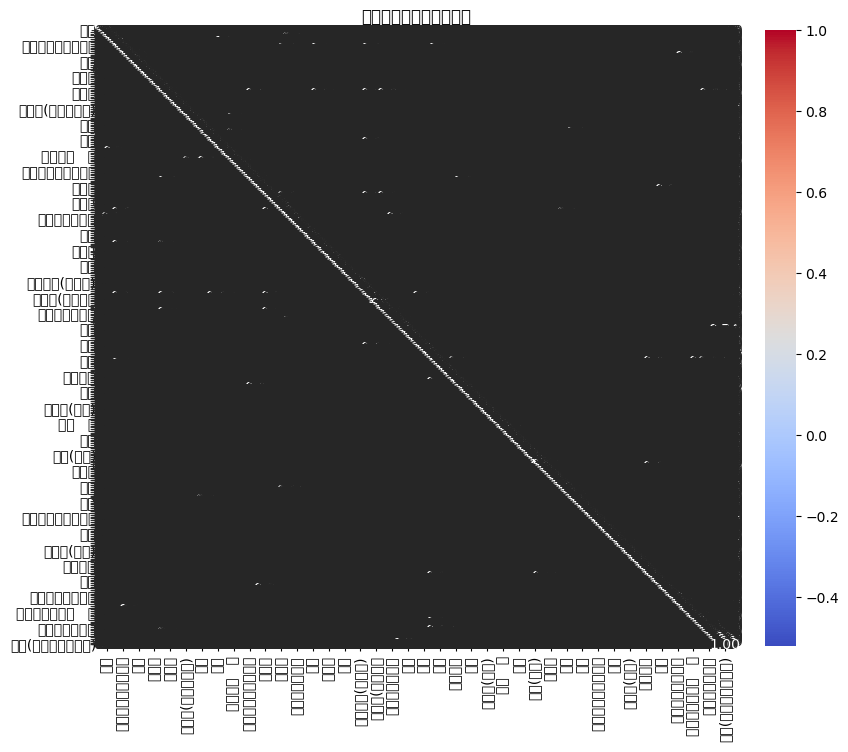

In [52]:
correlation_matrix = binary_matrix.corr()
import seaborn as sns
import matplotlib.pyplot as plt
# 3. 可视化
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("中药共现皮尔逊相关系数")
plt.show()


In [57]:
frequency[frequency > 600]

茯苓(云苓)                   6031
天麻                       4957
白术                       4687
川芎（酒川芎）                  4365
葛根                       3970
甘草（甘草片）                  3747
炙甘草                      3147
桂枝                       2779
法半夏                      2650
熟党参                      2609
石菖蒲                      2497
白芍                       2465
柴胡（北柴胡）                  2434
黄芪(北芪)                   2351
当归                       2049
陈皮（蒸陈皮）                  1985
半夏曲                      1846
丹参                       1774
黄芩                       1764
新会陈皮                     1758
五指毛桃(五爪龙)                1735
泽泻                       1578
白芷                       1561
牛膝                       1415
大枣(红枣)                   1310
威灵仙(灵仙)                  1193
生地黄(生地)                  1069
蒺藜(白七厘)                  1069
首乌藤（夜交藤）                 1032
人参片（生晒参）                 1005
砂仁                        934
赤芍                        927
钩藤                        926
木瓜(川木瓜)   

In [62]:
correlation_matrix

,丁香,三七片(田七片),三七粉（田七末 ) 袋,两面针(入地金牛),丹参,乌梅,乌药(台乌),九节菖蒲(外菖蒲),云芝,五味子（蒸五味子）,...,黄柏,黄精（酒黄精）,黄芩,黄芪(北芪),黄连,龙眼肉,龙胆（龙胆草）,龙葵,龙骨,龟甲(生龟甲、生龟板)
丁香,1.000000,-0.000212,-0.000237,-0.000106,-0.004883,-0.000184,-0.000237,-0.000150,-0.000335,-0.000572,...,-0.000237,-0.000335,-0.004876,-0.005878,-0.000450,-0.000184,-0.000150,-0.000150,-0.003046,-0.000184
三七片(田七片),-0.000212,1.000000,-0.000474,-0.000212,0.003533,-0.000367,-0.000474,-0.000300,-0.000671,-0.001144,...,-0.000474,-0.000671,-0.009753,0.012159,-0.000900,-0.000367,-0.000300,-0.000300,-0.006092,-0.000367
三七粉（田七末 ) 袋,-0.000237,-0.000474,1.000000,-0.000237,0.012872,-0.000411,-0.000530,-0.000335,-0.000750,-0.001279,...,-0.000530,-0.000750,0.001002,0.018943,-0.001007,-0.000411,-0.000335,-0.000335,-0.006811,-0.000411
两面针(入地金牛),-0.000106,-0.000212,-0.000237,1.000000,0.021712,-0.000184,-0.000237,-0.000150,-0.000335,-0.000572,...,-0.000237,-0.000335,-0.004876,-0.005878,-0.000450,-0.000184,-0.000150,-0.000150,-0.003046,-0.000184
丹参,-0.004883,0.003533,0.012872,0.021712,1.000000,-0.008458,0.000976,-0.006905,-0.007033,0.087422,...,-0.010920,0.043451,0.018938,0.047852,0.010637,-0.008458,0.011901,-0.006905,-0.082891,0.006898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
龙眼肉,-0.000184,-0.000367,-0.000411,-0.000184,-0.008458,-0.000318,-0.000411,-0.000260,-0.000581,-0.000990,...,-0.000411,-0.000581,-0.008446,0.031241,-0.000780,1.000000,-0.000260,-0.000260,-0.005276,-0.000318
龙胆（龙胆草）,-0.000150,-0.000300,-0.000335,-0.000150,0.011901,-0.000260,-0.000335,-0.000212,-0.000474,-0.000809,...,-0.000335,-0.000474,0.011928,-0.008313,-0.000637,-0.000260,1.000000,-0.000212,-0.004307,-0.000260
龙葵,-0.000150,-0.000300,-0.000335,-0.000150,-0.006905,-0.000260,-0.000335,-0.000212,-0.000474,-0.000809,...,-0.000335,-0.000474,0.030751,-0.008313,-0.000637,-0.000260,-0.000212,1.000000,-0.004307,-0.000260
龙骨,-0.003046,-0.006092,-0.006811,-0.003046,-0.082891,-0.005276,-0.006811,-0.004307,-0.009635,-0.009385,...,0.010121,-0.009635,0.219615,-0.094649,0.004928,-0.005276,-0.004307,-0.004307,1.000000,0.038439


In [64]:
all_herbs_list

[['熟地黄（熟地）',
  '白芍',
  '牛膝',
  '熟党参',
  '丹参',
  '首乌藤（夜交藤）',
  '茯神',
  '炙甘草',
  '法半夏',
  '厚朴(川朴/姜厚朴)',
  '麦冬'],
 ['天麻',
  '钩藤',
  '杜仲(盐杜仲)',
  '牛膝',
  '黄芩',
  '首乌藤（夜交藤）',
  '茯神',
  '川芎（酒川芎）',
  '法半夏',
  '白术',
  '茯苓(云苓)',
  '炙甘草',
  '生姜',
  '熟党参'],
 ['川芎（酒川芎）',
  '白芍',
  '牛膝',
  '天麻',
  '法半夏',
  '熟地黄（熟地）',
  '茯苓(云苓)',
  '炙甘草',
  '人参片（生晒参）',
  '木瓜(川木瓜)',
  '黄芪(北芪)',
  '生山萸肉（山萸肉、山茱萸、生山茱萸）',
  '麸炒白术（炒白术）',
  '麦冬',
  '川芎（酒川芎）',
  '赤芍',
  '牛膝',
  '天麻',
  '法半夏',
  '熟地黄（熟地）',
  '茯苓(云苓)',
  '炙甘草',
  '人参片（生晒参）',
  '木瓜(川木瓜)',
  '黄芪(北芪)',
  '生山萸肉（山萸肉、山茱萸、生山茱萸）',
  '麸炒白术（炒白术）',
  '麦冬'],
 ['茯苓(云苓)',
  '白术',
  '甘草（甘草片）',
  '葛根',
  '升麻',
  '黄芪(北芪)',
  '当归',
  '泽泻',
  '熟党参',
  '制远志(远志)',
  '龙骨',
  '牡蛎',
  '杜仲(盐杜仲)'],
 ['炒黄连', '桂枝', '熟党参', '当归'],
 ['龙眼肉',
  '新会陈皮',
  '人参片（生晒参）',
  '杜仲(盐杜仲)',
  '柴胡（北柴胡）',
  '苍术',
  '白术',
  '黄芪(北芪)',
  '天麻',
  '大枣(红枣)'],
 ['柴胡（北柴胡）', '当归', '白芍', '白术', '茯苓(云苓)', '炙甘草', '生姜', '天麻'],
 ['陈皮（蒸陈皮）',
  '大枣(红枣)',
  '炙甘草',
  '柴胡（北柴胡）',
  '当归',
  '黄芪(北芪)',
  '麸炒白术（炒白术）',
  '升麻',
  '

In [12]:
import pandas as pd
from sklearn.metrics import pairwise_distances

# 1. 生成布尔矩阵（同上）
# binary_df = ...
binary_array = binary_df.values
# 2. 计算 Jaccard 相似度矩阵
jaccard_sim = 1 - pairwise_distances(binary_array.T, metric="jaccard")
jaccard_df = pd.DataFrame(
    jaccard_sim,
    index=binary_df.columns,
    columns=binary_df.columns
)

# 3. 筛选高相关性药对（示例：相似度 > 0.5）
high_corr_pairs = []
for i in range(len(jaccard_df.columns)):
    for j in range(i+1, len(jaccard_df.columns)):
        herb1 = jaccard_df.columns[i]
        herb2 = jaccard_df.columns[j]
        sim = jaccard_df.iloc[i, j]
        if sim > 0.5:
            high_corr_pairs.append((herb1, herb2, sim))

# 转为 DataFrame 并排序
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["中药A", "中药B", "Jaccard相似度"])
high_corr_df = high_corr_df.sort_values(by="Jaccard相似度", ascending=False)

print("高共现中药对：")
print(high_corr_df)

高共现中药对：
                   中药A                 中药B  Jaccard相似度
0      三七粉（田七末  )    袋                 紫河车    1.000000
15     杜仲(盐杜仲) 量:20g:4  熟附子（黑顺片、附片） 量:5g:4    1.000000
30       苍耳子(炒苍耳子)   .              钩藤   .    1.000000
29           红芪 量:1袋:4    首乌藤（夜交藤） 量:15g:4    1.000000
28                 紫河车                 龟甲胶    1.000000
27                 紫河车              麝香   盒    1.000000
24          牛膝 量:20g:4    首乌藤（夜交藤） 量:15g:4    1.000000
23          牛膝 量:20g:4           红芪 量:1袋:4    1.000000
22  熟附子（黑顺片、附片） 量:5g:4    首乌藤（夜交藤） 量:15g:4    1.000000
21  熟附子（黑顺片、附片） 量:5g:4           红芪 量:1袋:4    1.000000
20  熟附子（黑顺片、附片） 量:5g:4          牛膝 量:20g:4    1.000000
18     杜仲(盐杜仲) 量:20g:4    首乌藤（夜交藤） 量:15g:4    1.000000
17     杜仲(盐杜仲) 量:20g:4           红芪 量:1袋:4    1.000000
1      三七粉（田七末  )    袋              麝香   盒    1.000000
16     杜仲(盐杜仲) 量:20g:4          牛膝 量:20g:4    1.000000
14        干益母草 量:20g:4    首乌藤（夜交藤） 量:15g:4    1.000000
10        干益母草 量:20g:4     杜仲(盐杜仲) 量:20g:4    1.000000
2 

In [8]:
binary_df

,丁香,三七片(田七片),三七粉（田七末 ) 袋,三七粉（田七末 ) 袋,三棱(醋三棱),丝瓜络(粤丝瓜络),两头尖,两面针(入地金牛),丹参,乌梅,...,黄连,黑枣,黑老虎,龙眼肉,龙胆（龙胆草）,龙脷叶（龙利叶）,龙葵,龙骨,龟甲(生龟甲、生龟板),龟甲胶
0,False,False,False,False,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9429,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9430,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9431,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
9432,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
binary_array = binary_df.values

In [10]:
binary_array

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [11]:
jaccard_sim = 1 - pairwise_distances(binary_array.T, metric="jaccard")

In [13]:
frequency

茯苓(云苓)                6031
天麻                    4957
白术                    4687
川芎（酒川芎）               4365
葛根                    3970
                      ... 
独活                       1
陈皮（蒸陈皮）                  1
苍术                       1
厚朴(川朴/姜厚朴)               1
当归炭                      1
Length: 588, dtype: int64

In [14]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 示例数据（每行是一个处方的药材列表）

all_herbs_list

# 2. 转换为布尔矩阵
te = TransactionEncoder()
te_ary = te.fit(all_herbs_list).transform(all_herbs_list)
binary_df = pd.DataFrame(te_ary, columns=te.columns_)



# 挖掘频繁项集（最小支持度设为0.2）
frequent_itemsets = apriori(
    binary_df, 
    min_support=0.2, 
    use_colnames=True, 
    max_len=2  # 最多挖掘2项集（二阶关联）
)

# 生成关联规则（最小提升度设为1.0）
rules = association_rules(
    frequent_itemsets, 
    metric="lift", 
    min_threshold=1.0
)

# 筛选二阶规则（前项为1项，后项为1项）
rules_2_order = rules[
    rules['antecedents'].apply(len) == 1
].sort_values(by='lift', ascending=False)

print("二阶关联规则（单药 → 单药）：")
print(rules_2_order[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

二阶关联规则（单药 → 单药）：
   antecedents consequents   support  confidence      lift
17        (葛根)   (川芎（酒川芎）)  0.276235    0.662430  1.445943
16   (川芎（酒川芎）)        (葛根)  0.276235    0.602962  1.445943
24   (甘草（甘草片）)        (葛根)  0.215921    0.552782  1.325608
25        (葛根)   (甘草（甘草片）)  0.215921    0.517794  1.325608
31    (茯苓(云苓))       (石菖蒲)  0.218041    0.346005  1.317277
30       (石菖蒲)    (茯苓(云苓))  0.218041    0.830105  1.317277
8         (天麻)        (葛根)  0.276129    0.532502  1.276976
9         (葛根)        (天麻)  0.276129    0.662176  1.276976
27    (茯苓(云苓))        (白术)  0.394636    0.626241  1.273266
26        (白术)    (茯苓(云苓))  0.394636    0.802371  1.273266
21        (白术)   (甘草（甘草片）)  0.240513    0.489009  1.251915
20   (甘草（甘草片）)        (白术)  0.240513    0.615739  1.251915
0         (天麻)   (川芎（酒川芎）)  0.296163    0.571137  1.246669
1    (川芎（酒川芎）)        (天麻)  0.296163    0.646460  1.246669
11   (川芎（酒川芎）)   (甘草（甘草片）)  0.222599    0.485886  1.243921
10   (甘草（甘草片）)   (川芎（酒川芎）)  0.222599   

In [15]:
# 挖掘频繁项集（允许3项集）
frequent_itemsets_3 = apriori(
    binary_df, 
    min_support=0.2, 
    use_colnames=True, 
    max_len=3  # 允许3项集
)

# 生成关联规则（提升度>1.0）
rules_3 = association_rules(
    frequent_itemsets_3, 
    metric="lift", 
    min_threshold=1.0
)

# 筛选三阶规则（前项2项，后项1项）
rules_3_order = rules_3[
    rules_3['antecedents'].apply(len) == 2
].sort_values(by='lift', ascending=False)

print("三阶关联规则（两药 → 单药）：")
print(rules_3_order[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

三阶关联规则（两药 → 单药）：
          antecedents consequents   support  confidence      lift
40      (天麻, 川芎（酒川芎）)        (葛根)  0.206275    0.696492  1.670236
66       (茯苓(云苓), 葛根)   (川芎（酒川芎）)  0.225143    0.756680  1.651670
41           (天麻, 葛根)   (川芎（酒川芎）)  0.206275    0.747025  1.630595
64  (茯苓(云苓), 川芎（酒川芎）)        (葛根)  0.225143    0.669820  1.606275
34       (天麻, 茯苓(云苓))   (川芎（酒川芎）)  0.228429    0.671549  1.465847
52       (天麻, 茯苓(云苓))        (葛根)  0.207759    0.610782  1.464697
59  (茯苓(云苓), 川芎（酒川芎）)        (白术)  0.239241    0.711763  1.447149
42      (葛根, 川芎（酒川芎）)        (天麻)  0.206275    0.746738  1.440051
47       (天麻, 茯苓(云苓))        (白术)  0.240407    0.706762  1.436982
71       (茯苓(云苓), 葛根)        (白术)  0.206381    0.693623  1.410267
72           (白术, 葛根)    (茯苓(云苓))  0.206381    0.871531  1.383015
60      (白术, 川芎（酒川芎）)    (茯苓(云苓))  0.239241    0.863428  1.370156
54       (茯苓(云苓), 葛根)        (天麻)  0.207759    0.698254  1.346552
58       (白术, 茯苓(云苓))   (川芎（酒川芎）)  0.239241    0.606232  1.

In [16]:
rules_3_order

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
40,"(天麻, 川芎（酒川芎）)",(葛根),0.296163,0.417002,0.206275,0.696492,1.670236,0.082775,1.920867,0.570135
66,"(茯苓(云苓), 葛根)",(川芎（酒川芎）),0.297541,0.458130,0.225143,0.756680,1.651670,0.088831,2.226982,0.561673
41,"(天麻, 葛根)",(川芎（酒川芎）),0.276129,0.458130,0.206275,0.747025,1.630595,0.079772,2.141989,0.534249
64,"(茯苓(云苓), 川芎（酒川芎）)",(葛根),0.336125,0.417002,0.225143,0.669820,1.606275,0.084978,1.765698,0.568543
34,"(天麻, 茯苓(云苓))",(川芎（酒川芎）),0.340153,0.458130,0.228429,0.671549,1.465847,0.072595,1.649773,0.481627
52,"(天麻, 茯苓(云苓))",(葛根),0.340153,0.417002,0.207759,0.610782,1.464697,0.065915,1.497870,0.480816
59,"(茯苓(云苓), 川芎（酒川芎）)",(白术),0.336125,0.491838,0.239241,0.711763,1.447149,0.073922,1.763000,0.465428
42,"(葛根, 川芎（酒川芎）)",(天麻),0.276235,0.518550,0.206275,0.746738,1.440051,0.063034,1.900998,0.422209
47,"(天麻, 茯苓(云苓))",(白术),0.340153,0.491838,0.240407,0.706762,1.436982,0.073107,1.732935,0.460859
71,"(茯苓(云苓), 葛根)",(白术),0.297541,0.491838,0.206381,0.693623,1.410267,0.060039,1.658617,0.414137


In [19]:
import xlwings as xw
xw.view(rules_3_order)

TypeError: must be real number, not frozenset

In [20]:
with pd.ExcelWriter(r'C:\Users\xinre\Desktop\关联规则结果.xlsx') as writer:
    # 保存二阶规则到第一个工作表
    rules_2_order.to_excel(
        writer,
        sheet_name='二阶关联规则',
        index=False  # 不保存索引列
    )
    
    # 保存三阶规则到第二个工作表
    rules_3_order.to_excel(
        writer,
        sheet_name='三阶关联规则',
        index=False,
        startrow=0  # 从第一行开始写入（默认行为）
    )

In [22]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 数据预处理（保持不变）
# 示例数据（每行是一个处方的药材列表）

all_herbs_list

# 2. 转换为布尔矩阵
te = TransactionEncoder()
te_ary = te.fit(all_herbs_list).transform(all_herbs_list)
binary_df = pd.DataFrame(te_ary, columns=te.columns_)


# 生成二阶规则（修改部分）
frequent_itemsets_2 = apriori(binary_df, min_support=0.2, use_colnames=True, max_len=2)
rules_2 = association_rules(frequent_itemsets_2, metric="lift", min_threshold=1.0)

# 转换集合为字符串
def frozenset_to_str(column):
    return column.apply(lambda x: ', '.join(list(x)))

rules_2['antecedents'] = frozenset_to_str(rules_2['antecedents'])
rules_2['consequents'] = frozenset_to_str(rules_2['consequents'])

# 筛选并排序
rules_2_order = rules_2[rules_2['antecedents'].apply(lambda x: len(x.split(', ')) == 1)].sort_values(by='lift', ascending=False)

# 生成三阶规则（修改部分）
frequent_itemsets_3 = apriori(binary_df, min_support=0.2, use_colnames=True, max_len=3)
rules_3 = association_rules(frequent_itemsets_3, metric="lift", min_threshold=1.0)

# 转换集合为字符串
rules_3['antecedents'] = frozenset_to_str(rules_3['antecedents'])
rules_3['consequents'] = frozenset_to_str(rules_3['consequents'])

# 筛选并排序
rules_3_order = rules_3[rules_3['antecedents'].apply(lambda x: len(x.split(', ')) == 2)].sort_values(by='lift', ascending=False)

# 保存为Excel（保持不变）
with pd.ExcelWriter(r'C:\Users\xinre\Desktop\关联规则结果.xlsx') as writer:
    rules_2_order[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_excel(
        writer,
        sheet_name='二阶关联规则',
        index=False
    )
    rules_3_order[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_excel(
        writer,
        sheet_name='三阶关联规则',
        index=False,
        startrow=0
    )

print("优化后的结果已保存至关联规则结果.xlsx")

优化后的结果已保存至关联规则结果.xlsx


In [2]:
import pandas as pd
df=pd.read_excel(r"C:\Users\xinre\Desktop\副本723362e533ae5339337c9115433aa483_9172efbc9ea48deb4d61c52119002e70_8.xlsx",sheet_name='内服中药（不同科室）')
df.pop('就诊科室')
chinese_herbs_columns = ['内服中药'] + [col for col in df.columns if 'Unnamed' in col and df[col].notnull().any()]  
for col in chinese_herbs_columns:  
        df[col] = df[col].str.split("量:", expand=True)[0].str.strip() 
#数据清洗一下

In [3]:
import xlwings as xw
xw.view(df)

In [5]:
import pandas as pd
df=pd.read_excel(r"C:\Users\xinre\Desktop\副本723362e533ae5339337c9115433aa483_9172efbc9ea48deb4d61c52119002e70_8.xlsx",sheet_name='内服中药（不同科室）')
df.pop('就诊科室')

chinese_herbs_columns = ['内服中药'] + [col for col in df.columns if 'Unnamed' in col and df[col].notnull().any()]  
for col in chinese_herbs_columns:  
        df[col] = df[col].str.split("量:", expand=True)[0] .str.replace(r"\s+", " ", regex=True).str.strip()    

In [6]:
df

,内服中药,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76
0,熟地黄（熟地）,白芍,牛膝,熟党参,丹参,首乌藤（夜交藤）,茯神,炙甘草,知母,黄连,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,天麻,钩藤,石决明,麸炒枳实,杜仲(盐杜仲),牛膝,黄芩,桑寄生(杂寄生）,首乌藤（夜交藤）,茯神,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,川芎（酒川芎）,白芍,牛膝,天麻,法半夏,熟地黄（熟地）,茯苓(云苓),炙甘草,人参片（生晒参）,木瓜(川木瓜),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,茯苓(云苓),白术,甘草（甘草片）,葛根,升麻,黄芪(北芪),当归,泽泻,蔓荆子（荆子）,熟党参,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,炒黄连,关黄柏(黄柏),熟附子（黑顺片、附片）,细辛,桂枝,花椒(川椒),乌梅,干姜,熟党参,当归,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9429,甘草（甘草片）,川芎（酒川芎）,藁本,牛膝,柴胡（北柴胡）,新会陈皮,熟地黄（熟地）,竹茹,半夏曲,蒺藜(白七厘),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9430,生山萸肉（山萸肉、山茱萸、生山茱萸）,蒺藜(白七厘),酒川牛膝,宽筋藤,延胡索(醋延胡索/玄胡索/元胡/制延胡索),天麻,白芷,甘草（甘草片）,灯盏细辛(灯盏花) 袋,白术,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9431,法半夏,天麻,白术,熟党参,川芎（酒川芎）,蒺藜(白七厘),黄芪(北芪),白芍,丹参,鹿衔草（鹿含草）,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9432,络石藤(广东络石藤),杜仲(盐杜仲),天麻,赤芍,茯苓(云苓),钩藤,夏枯草,丹参,泽泻,菊花,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
xw.view(df)

In [13]:
df.iloc[8901].value_counts()

新会陈皮           4
砂仁             4
熟附子（黑顺片、附片）    4
牛膝             4
杜仲(盐杜仲)        4
干益母草           4
半夏曲            4
天麻             4
茯神             4
石菖蒲            4
炒酸枣仁           4
合欢皮            4
冬凌草            4
化橘红胎（化橘红珠）     4
珍珠母            4
首乌藤（夜交藤）       4
红芪 袋           3
煅牡蛎            2
麸炒白术（炒白术）      2
土白术（土炒白术）      2
牡蛎             2
红芪             1
Name: 8901, dtype: int64

In [2]:
frequency

茯苓(云苓)            6032
天麻                4960
白术                4688
川芎（酒川芎）           4366
葛根                3972
                  ... 
康复三号方                1
紫珠草（大叶紫珠/紫珠叶）        1
萸黄连(吴萸黄连)            1
更年滋养协定方（代加工） 瓶       1
当归炭                  1
Length: 514, dtype: int64